# Populations and Catalogs

We will be working toward a full analysis of the mass function from {cite}`Schneider2018`.  The data can be downloaded [here](https://www.science.org/doi/10.1126/science.aan0106) and consist of estimates of the stellar properties of massive stars observed in the 30 Doradus star forming region with the VLT-FLAMES survey.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [50]:
import astropy.io.ascii as aia
import pandas as pd
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import re
from scipy.stats import gaussian_kde
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

In [66]:
data_30dor = aia.read('data/aan0106_data_s1.txt', delimiter='\t', 
                      names=['VFTS Identifier', 'Spectral type', 
                             'logL', 'd+logL', 'd-logL', 'logLCI', 
                             'Teff', 'd+Teff', 'd-Teff', 'TeffCI', 
                             'logg', 'd+logg', 'd-logg', 'loggCI',
                             'vsini', 'd+vsini', 'd-vsini', 'vsiniCI',
                             'Y', 'd+Y', 'd-Y', 'YCI',
                             'Reference', 
                             'Mini', 'd+Mini', 'd-Mini', 'MiniCI',
                             'vini', 'd+vini', 'd-vini', 'viniCI',
                             'Age', 'd+Age', 'd-Age', 'AgeCI',
                             'Mpresent', 'd+Mpresent', 'd-Mpresent', 'MpresentCI',
                             'R', 'd+R', 'd-R', 'RCI'],
                      fill_values=[('-', 'NaN'), ('25.0-30.0', 'NaN'), ('30.0-60.0', 'NaN'), ('>25.0', 'NaN'), ('>27.0', 'NaN'),
                                   ('18.5-47.7', 'NaN'), ('16.5-41.8', 'NaN'), ('7.9-12.9', 'NaN'), ('25.8-54.1', 'NaN'),
                                   ('4.5-8.0', 'NaN'), ('22.4-39.4', 'NaN'), ('3.5-8.0', 'NaN'), ('21.5-37.5', 'NaN'),
                                   ('17.0-30.6', 'NaN'), ('12.7-22.1', 'NaN'), ('7.3-11.8', 'NaN'), ('5.7-9.0', 'NaN'),
                                   ('28.2-62.4', 'NaN'), ('9.1-14.8', 'NaN'), ('11.2-18.9', 'NaN'), ('23.9-50.7', 'NaN'),
                                   ('10.6-17.8', 'NaN'), ('20.2-35.8', 'NaN'), ('8.3-13.5', 'NaN'), ('6.0-9.5', 'NaN'),
                                   ('14.8-26.8', 'NaN'), ('18.5-33.7', 'NaN'), ('11.2-18.9', 'NaN'), ('3.5-5.3', 'NaN'),
                                   ('47.9-79.6', 'NaN'), ('47.8-79.6', 'NaN'), ('4.6-7.1', 'NaN'), ('5.5-8.8', 'NaN'), ('16.0-54.2', 'NaN'),
                                   ('3.0-8.5', 'NaN'), ('3.6-5.5', 'NaN'), ('4.3-8.9', 'NaN'), ('15.6-28.0', 'NaN'), ('20.3-47.5', 'NaN'),
                                   ('16.1-28.0', 'NaN'), ('11.0-18.4', 'NaN'), ('4.1-6.3', 'NaN'), ('14.5-33.8', 'NaN'), ('12.7-22.1', 'NaN'),
                                   ('7.6-12.4', 'NaN'), ('8.3-13.5', 'NaN'), ('5.9-9.4', 'NaN'), ('13.3-22.9', 'NaN'), ('10.0-16.9', 'NaN'),
                                   ('12.7-22.1', 'NaN'), ('5.9-9.4', 'NaN'), ('12.3-20.7', 'NaN'), ('21.5-39.4', 'NaN'), ('14.1-23.9', 'NaN'),
                                   ('23.2-42.2', 'NaN'), ('32.6-62.6', 'NaN'), ('7.0-8.5', 'NaN')]).to_pandas()
data_30dor

,VFTS Identifier,Spectral type,logL,d+logL,d-logL,logLCI,Teff,d+Teff,d-Teff,TeffCI,...,d-Age,AgeCI,Mpresent,d+Mpresent,d-Mpresent,MpresentCI,R,d+R,d-R,RCI
0,3,B1 Ia+,6.03,0.10,0.10,68.3,21000.0,1000.0,1000.0,68.3,...,0.3,68.3,56.4,10.3,7.8,69.2,74.2,16.1,9.2,68.3
1,4,B2 V,3.85,0.10,0.10,68.3,20000.0,1020.0,1020.0,68.3,...,3.3,68.3,8.0,0.5,0.4,68.3,5.7,0.8,0.6,68.3
2,5,B2 V(n),3.82,0.10,0.10,68.3,19000.0,1000.0,1000.0,68.3,...,3.0,68.3,8.0,0.4,0.6,68.3,7.7,0.9,0.7,68.3
3,6,Mid-late K,3.46,0.20,0.20,68.3,4100.0,150.0,150.0,68.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,B1-2 V,3.64,0.11,0.11,68.3,20000.0,1210.0,1210.0,68.3,...,4.2,68.3,7.4,0.4,0.6,68.3,5.7,0.8,0.6,68.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,1001,WN6(h),6.20,0.10,0.10,68.3,42170.0,1520.0,1520.0,68.3,...,0.3,68.3,57.6,11.6,6.5,68.3,27.7,2.8,4.5,68.3
567,1017,O2 If*/WN5,6.21,0.10,0.10,68.3,50120.0,1800.0,1800.0,68.3,...,0.4,68.3,79.0,17.8,15.9,69.9,16.9,2.7,2.7,68.3
568,1021,O4 If+,6.10,0.10,0.10,68.3,35500.0,1500.0,1500.0,68.3,...,0.2,68.3,71.4,12.7,9.2,68.5,30.1,4.2,3.3,68.3
569,1022,O3.5 If*/WN7,6.48,0.10,0.10,68.3,42170.0,1520.0,1520.0,68.3,...,0.1,68.3,142.8,25.6,25.2,68.3,32.5,4.7,4.4,68.3


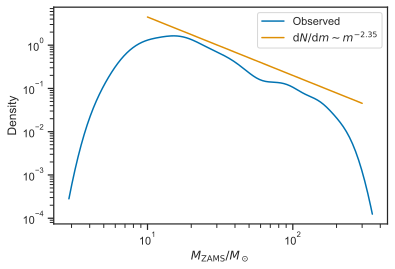

In [4]:
sns.kdeplot(data_30dor['Mini'], log_scale=True, label='Observed')
ms = exp(linspace(log(10), log(300), 100))
plot(ms, 100*ms*ms**-2.35, label=r'$\mathrm{d}N/\mathrm{d}m \sim m^{-2.35}$')
yscale('log')
xlabel(r'$M_\mathrm{ZAMS} / M_\odot$')
legend(loc='best')

In class we derived the inhomogeneous Poisson likelihood.  For stars that occur with a I.H.P. rate (aka "intensity")
$$
\frac{\mathrm{d} N}{\mathrm{d} m} 
$$
the likelihood for observations $m_i$ is 
$$
p\left( \left\{ m_i \mid i = 1, \ldots, n \right\} \mid \ldots \right) = \exp\left( - N \right) \prod_{i=1}^n \frac{\mathrm{d} N}{\mathrm{d} m_i };
$$
here the $\ldots$ stand in for whatever parameters we need to specify the intensity.

Let's fit a power-law intensity to the $m$ estimates from {cite}`Schneider2018`.  We will parameterize the power law by 
$$
\frac{\mathrm{d} N}{\mathrm{d} m} = \frac{A}{m_\mathrm{min}} \left( \frac{m}{m_\mathrm{min}} \right)^{-\alpha}.
$$
Here $A$, an "amplitude" parameter, corresponds to the differential star formation rate *per (natural) log mass* at $m = m_\mathrm{min}$:
$$
\left. m \frac{\mathrm{d} N}{\mathrm{d} m} \right|_{m = m_\mathrm{min}} = \left. \frac{\mathrm{d} N}{\mathrm{d} \ln m} \right|_{m = m_\mathrm{min}} = A
$$
the "power law slope" is $-\alpha$.  We will fix $m_\mathrm{min} = 20 \, M_\odot$ is our analysis because we are not yet ready to face the selection effects plaguing lower masses (lower mass stars are dimmer, and therefore harder to obtain spectra for, and therefore appear under-represented in the above data set), and it looks like the observations are approximately power-law for $m > 20 \, M_\odot$.

We will need the integral of the intensity:
$$
\Lambda \equiv \int_{m_\mathrm{min}}^\infty \mathrm{d} m \, \frac{\mathrm{d}N}{\mathrm{d} m} = \frac{A}{\alpha-1}
$$
as long as $\alpha > 1$.  As long as $\alpha \simeq 1$, we expect that $A$ will be comparable to the total number of observations ($\sim 500$ in total, though only about 140 with masses above $20 \, M_\odot$).

In order to make nice plots, we produce $\mathrm{d} N/\mathrm{d} m$ on a grid of masses as a deterministic output of the model (we could produce this after the fact, but doing it this way ensures that the output $\mathrm{d}N/\mathrm{d}m$ and the inferred shape function are consistent, including the normalization term).

In [5]:
MMin = 20
masses = data_30dor['Mini']
masses = masses[(~isnan(masses)) & (masses > MMin)]

mgrid = exp(arange(log(MMin), log(500), 0.01))

with pm.Model() as salp_model:
    # dN/dm = (A/20)*(m/20)^-alpha
    alpha = pm.Bound(pm.Normal, lower=1)('alpha', mu=2.5, sigma=1)
    A = pm.Lognormal('A', mu=log(140), sigma=1)

    def log_dNdm(m):
        return tt.log(A) - tt.log(MMin) - alpha*(tt.log(m) - tt.log(MMin))
    
    Lambda = pm.Deterministic('Lambda', A/(alpha-1))
    
    # sum(log(dN/dm_i)) - Lambda
    pm.Potential('likelihood', tt.sum(log_dNdm(masses)))
    pm.Potential('normalization', -Lambda)
    
    dNdm_grid = pm.Deterministic('dNdm_grid', exp(log_dNdm(mgrid)))

In [6]:
with salp_model:
    salp_trace = pmx.sample()

/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.


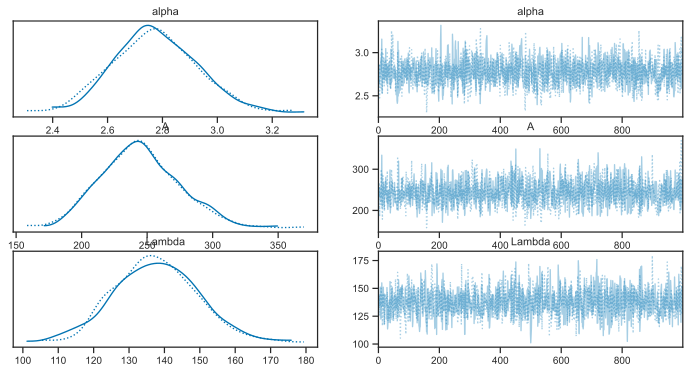

In [7]:
with salp_model:
    pm.plot_trace(salp_trace, var_names=['alpha', 'A', 'Lambda'])

Let's plot the inferred intensity and compare to the observed intensity.

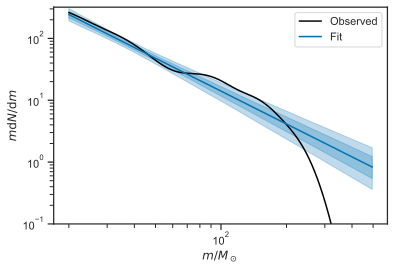

In [8]:
all_valid_masses = data_30dor['Mini']
all_valid_masses = all_valid_masses[~isnan(all_valid_masses)]
logm_density = gaussian_kde(log(all_valid_masses))

plot(mgrid, len(all_valid_masses)*logm_density(log(mgrid)), color='k', label='Observed')

l, = plot(mgrid, mgrid*median(salp_trace['dNdm_grid'], axis=0), label='Fit')
fill_between(mgrid, mgrid*quantile(salp_trace['dNdm_grid'], 0.84, axis=0), mgrid*quantile(salp_trace['dNdm_grid'], 0.16, axis=0), alpha=0.25, color=l.get_color())
fill_between(mgrid, mgrid*quantile(salp_trace['dNdm_grid'], 0.975, axis=0), mgrid*quantile(salp_trace['dNdm_grid'], 0.025, axis=0), alpha=0.25, color=l.get_color())

axis(ymin=0.1)
xscale('log')
yscale('log')

xlabel(r'$m / M_\odot$')
ylabel(r'$m \mathrm{d} N / \mathrm{d} m$')

legend(loc='best')

Now let's take into account that the masses are *estimated* with uncertanty; the *unknown* true masses will follow a power law, with the observed masses related to the true masses by a Gaussian likelihood:

In [9]:
MMin = 20
mask = (~isnan(data_30dor['Mini'])) & (data_30dor['Mini'] > MMin)
obs_masses = np.array(data_30dor['Mini'].loc[mask])
sigma_masses = np.array(0.5*(data_30dor['d+Mini'].loc[mask] + data_30dor['d-Mini'].loc[mask]))

mgrid = exp(arange(log(MMin), log(500), 0.01))

with pm.Model() as salp_model_hier:
    # dN/dm = (A/20)*(m/20)^-alpha
    alpha = pm.Bound(pm.Normal, lower=1)('alpha', mu=2.5, sigma=1)
    A = pm.Lognormal('A', mu=log(140), sigma=1)

    true_masses = pm.Bound(pm.Flat, lower=MMin)('true_masses', shape=len(obs_masses))
    
    def log_dNdm(m):
        return tt.log(A) - tt.log(MMin) - alpha*(tt.log(m) - tt.log(MMin))
    
    Lambda = pm.Deterministic('Lambda', A/(alpha-1))
    
    # sum(log(dN/dm_i)) - Lambda
    pm.Potential('likelihood', tt.sum(log_dNdm(true_masses)))
    pm.Potential('normalization', -Lambda)
    
    pm.Normal('obs_likelihood', mu=true_masses, sigma=sigma_masses, observed=obs_masses)
    
    dNdm_grid = pm.Deterministic('dNdm_grid', exp(log_dNdm(mgrid)))

In [10]:
with salp_model_hier:
    salp_trace_hier = pmx.sample(init={'true_masses': obs_masses}, adapt_type='diag')

/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [true_masses, A, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
The number of effective samples is smaller than 25% for some parameters.


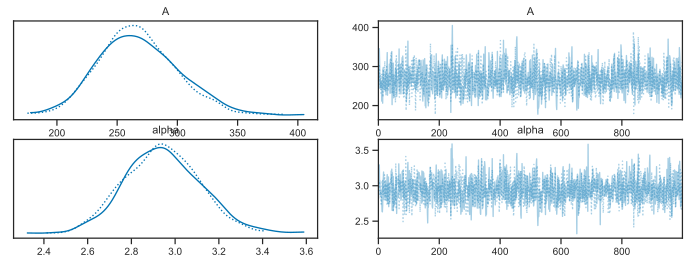

In [12]:
with salp_model_hier:
    pm.plot_trace(salp_trace_hier, var_names=['A', 'alpha'])

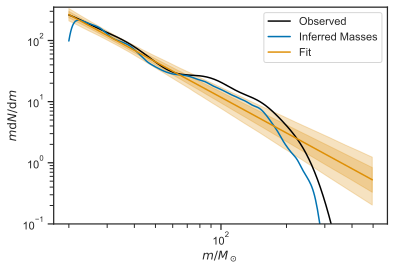

In [20]:
all_valid_masses = data_30dor['Mini']
all_valid_masses = all_valid_masses[~isnan(all_valid_masses)]
logm_density = gaussian_kde(log(all_valid_masses))

logm_true_density = gaussian_kde(log(salp_trace_hier['true_masses'].ravel()))

plot(mgrid, len(all_valid_masses)*logm_density(log(mgrid)), color='k', label='Observed')
plot(mgrid, len(obs_masses)*logm_true_density(log(mgrid)), label='Inferred Masses')

l, = plot(mgrid, mgrid*median(salp_trace_hier['dNdm_grid'], axis=0), label='Fit')
fill_between(mgrid, mgrid*quantile(salp_trace_hier['dNdm_grid'], 0.84, axis=0), mgrid*quantile(salp_trace_hier['dNdm_grid'], 0.16, axis=0), alpha=0.25, color=l.get_color())
fill_between(mgrid, mgrid*quantile(salp_trace_hier['dNdm_grid'], 0.975, axis=0), mgrid*quantile(salp_trace_hier['dNdm_grid'], 0.025, axis=0), alpha=0.25, color=l.get_color())

axis(ymin=0.1)
xscale('log')
yscale('log')

xlabel(r'$m / M_\odot$')
ylabel(r'$m \mathrm{d} N / \mathrm{d} m$')

legend(loc='best')

Next steps:

* Broken power law.
* What about high-mass absence from aging?
* ***Selection Effects*** (handle the mass boundary appropriately).

Here we will account for the finite and *mass-dependent* stellar lifetime that reduces the number of high-mass stars in our sample, and therefore steepens the slope.  We assume that stars form in a Poisson process in *mass* and in *time* via
$$
\frac{\mathrm{d} N}{\mathrm{d} m \mathrm{d} t} = \frac{A}{m} \left( \frac{m}{m_\mathrm{min}} \right)^{-\alpha} \exp\left( - \frac{\left( t - \mu_t\right)^2}{2 \sigma_t^2} \right).
$$
Here $A$ is the number of stars formed per natural log mass per time at $m = m_\mathrm{min}$ and $t = \mu_t$ (that is, at time of the peak star formation rate). 

In [82]:
mask = (~isnan(data_30dor['Mini'])) & (~isnan(data_30dor['Age'])) & (data_30dor['Age'] > 0)

Text(0.5, 21.500000000000043, '$t / \\mathrm{Myr}$')

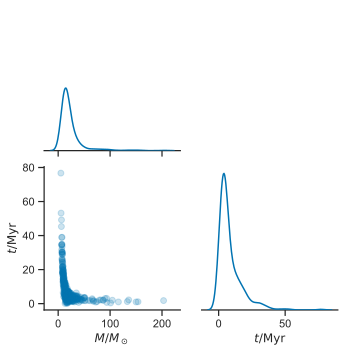

In [95]:
pg = sns.PairGrid(data_30dor[mask], vars=['Mini', 'Age'], corner=True)
pg.map_diag(sns.kdeplot)
pg.map_lower(scatter, alpha=0.2)
pg.axes[1,0].set_xlabel(r'$M/M_\odot$')
pg.axes[1,0].set_ylabel(r'$t / \mathrm{Myr}$')
pg.axes[1,1].set_xlabel(r'$t / \mathrm{Myr}$')

If we zoom in on the lower-mass part of the plot here, we see that for sufficiently low masses, there is a one-to-one relationship between the mass and the age; this is a result of the giant branch: for these low-mass stars, they can only be seen when they are in the giant phase, which is quite short, so there is one, definite formation time that puts the star on the giant branch today.  We want to cut out these stars, since they do not give us a continuous picture of the mass and time evolution of the star formation; we can accomplish this by cutting out stars below $\sim 15 \, M_\odot$.

A crucial parameter is the maximum age of any star at a given mass before it becomes a compact remnant.  This can be found in {cite}`Farr201830Dor`; their fitting formula for the main-sequence lifetime as a function of mass is 
$$
\log \frac{\tau\left( M \right)}{\mathrm{Myr}} = 9.1973 - 3.8955 \log \frac{M}{M_\odot} + 0.6107 \left( \log \frac{M}{M_\odot} \right)^2 - 0.0332 \left( \log \frac{M}{M_\odot} \right)^3.
$$
The full lifetime is 10% longer than the main sequence lifetime to account for the post-main-sequence helium burning in these massive stars.

In [101]:
def lifetime(M):
    x = tt.log(M)
    return 1.1*tt.exp(9.1973 + x*(-3.8955 + x*(0.6107 - x*0.0332)))

Text(0, 0.5, '$t / \\mathrm{Myr}$')

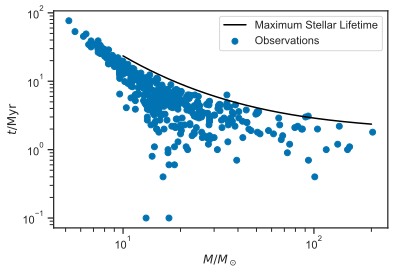

In [105]:
scatter(data_30dor['Mini'].loc[mask], data_30dor['Age'].loc[mask], label='Observations')

m = exp(linspace(log(10), log(200), 1024))
plot(m, lifetime(m).eval(), color='k', label='Maximum Stellar Lifetime')

legend(loc='best')

xscale('log')
yscale('log')
xlabel(r'$M / M_\odot$')
ylabel(r'$t / \mathrm{Myr}$')